# Resolução da Equação do Calor 1D com o Método das Linhas

Este notebook demonstra como resolver a equação do calor 1D transiente usando o **Método das Linhas (MOL)**.

A equação do calor é uma equação diferencial parcial (EDP) parabólica dada por:
$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$

Onde:
- $u(x,t)$ é a temperatura na posição $x$ e no tempo $t$.
- $\alpha$ é a difusividade térmica do material.

A estratégia do MOL consiste em:
1. **Discretizar o domínio espacial**: Substituímos a dimensão espacial `x` por uma grade de pontos discretos.
2. **Aproximar as derivadas espaciais**: Usamos o método das diferenças finitas para aproximar a segunda derivada $\frac{\partial^2 u}{\partial x^2}$.
3. **Transformar a EDP em um sistema de EDOs**: Após a discretização espacial, a EDP original se transforma em um grande sistema de equações diferenciais ordinárias (EDOs), uma para cada ponto da grade.
4. **Resolver o sistema de EDOs**: Usamos um solver de EDOs robusto, como o `solve_ivp` da biblioteca SciPy, para resolver o sistema no tempo.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

### 1. Definição do Problema e Parâmetros

Definimos os parâmetros físicos (comprimento da barra, difusividade, tempo final), os parâmetros numéricos (número de pontos na malha) e as condições iniciais e de contorno.

In [16]:
# Parâmetros Físicos
L = 1.0  # Comprimento da barra [m]
alpha = 1e-4  # Difusividade térmica [m^2/s]
t_final = 60.0  # Tempo final da simulação [s]

# Parâmetros Numéricos
N = 500  # Número de pontos internos na malha
dx = L / (N + 1)  # Espaçamento entre os pontos

# Malha Espacial
# Inclui os pontos de contorno 0 e L
x = np.linspace(0, L, N + 2)

# Condições de Contorno (Dirichlet)
T0 = 0.0  # Temperatura em x=0
TL = 0.0  # Temperatura em x=L

# Condição Inicial
# Um pulso senoidal de temperatura no meio da barra
U0 = np.sin(np.pi * x / L)

# O vetor U para o solver de EDOs contém apenas os pontos internos,
# pois os pontos de contorno são fixos.
U0_internal = U0[1:-1]

### 2. Função para o Sistema de EDOs

Esta é a função principal do Método das Linhas. Ela calcula a derivada temporal (`dU/dt`) para cada ponto interno da malha, dado o estado atual `U`.

A função tem a assinatura `f(t, y)` exigida pelo `solve_ivp`.

In [17]:
def heat_equation_rhs(t, U_internal):
    """
    Calcula o lado direito (RHS) do sistema de EDOs para a equação do calor.
    U_internal: vetor de temperaturas nos pontos internos da malha.
    t: tempo atual (não usado nesta equação, mas exigido pelo solver).
    """
    # Recriamos o vetor completo de temperaturas, incluindo os contornos
    U_full = np.concatenate(([T0], U_internal, [TL]))

    # Calculamos a segunda derivada espacial usando diferenças finitas centradas
    # d^2U/dx^2 ≈ (U_{i+1} - 2*U_i + U_{i-1}) / dx^2
    # Usamos a forma vetorizada do NumPy para eficiência
    laplacian = (U_full[2:] - 2 * U_full[1:-1] + U_full[:-2]) / dx**2

    # O resultado é dU/dt para cada ponto interno
    dUdt = alpha * laplacian

    return dUdt

### 3. Resolução do Sistema de EDOs

Agora, passamos a função do sistema de EDOs, o intervalo de tempo e a condição inicial para o `solve_ivp`. Usamos o método `'Radau'`, que é robusto para problemas "rígidos" (*stiff*), como a equação do calor discretizada.

In [18]:
sol = solve_ivp(
    fun=heat_equation_rhs,  # A função que define o sistema
    t_span=[0, t_final],  # Intervalo de tempo da integração
    y0=U0_internal,  # Condição inicial (apenas pontos internos)
    method="Radau",  # Solver robusto para problemas rígidos
    dense_output=True,  # Permite interpolar a solução em qualquer tempo
)

print(f"Solver status: {sol.message}")
print(f"Número de passos de tempo: {len(sol.t)}")

Solver status: The solver successfully reached the end of the integration interval.
Número de passos de tempo: 5


### 4. Visualização dos Resultados

Vamos visualizar como o perfil de temperatura evolui ao longo do tempo.

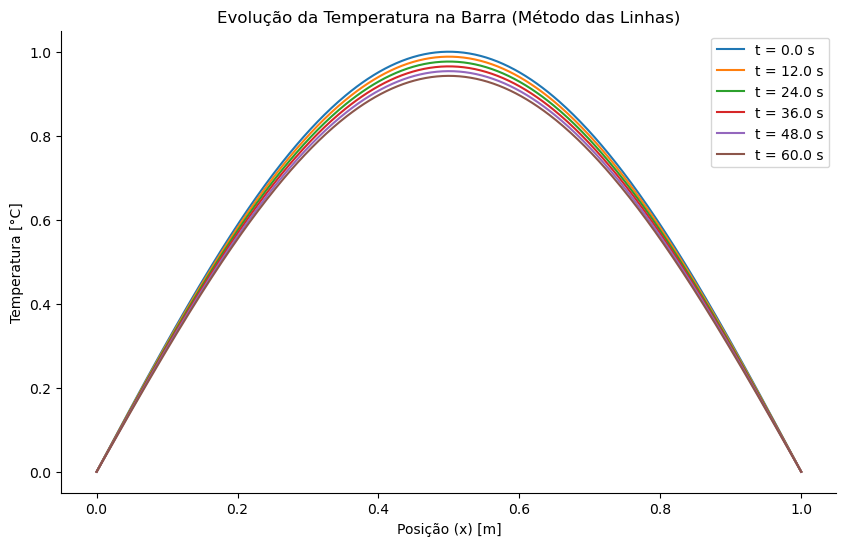

In [19]:
# Tempos nos quais queremos visualizar a solução
plot_times = np.linspace(0, t_final, 6)

# Avalia a solução (obtida pelo dense_output) nos tempos desejados
U_sol_internal = sol.sol(plot_times)

plt.figure(figsize=(10, 6))

for i, t in enumerate(plot_times):
    # Monta o vetor de solução completo (com contornos) para o tempo t
    U_plot = np.concatenate(([T0], U_sol_internal[:, i], [TL]))
    plt.plot(x, U_plot, label=f"t = {t:.1f} s")

plt.title("Evolução da Temperatura na Barra (Método das Linhas)")
plt.xlabel("Posição (x) [m]")
plt.ylabel("Temperatura [°C]")
plt.legend()

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### 5. Visualização 2D (Mapa de Calor)

Uma forma ainda mais completa de ver a solução é através de um mapa de calor, que mostra a temperatura em função da posição (eixo x) e do tempo (eixo y).

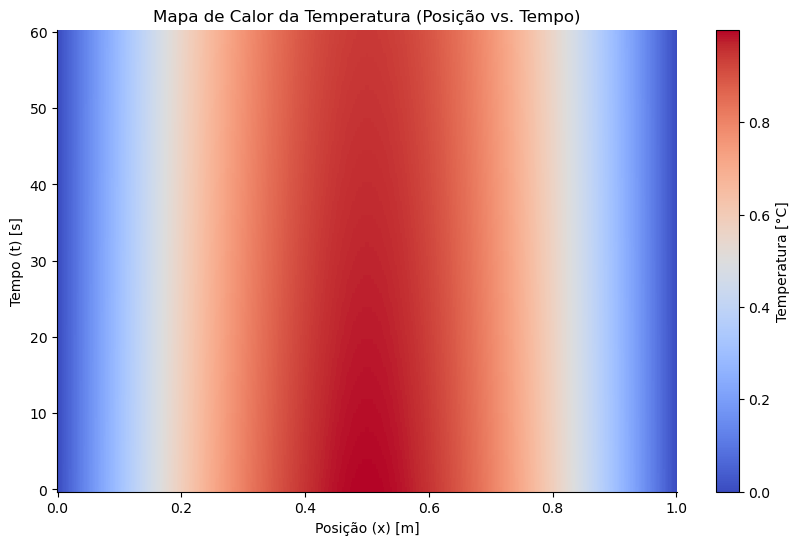

In [20]:
# Criamos uma grade mais fina de tempos para uma visualização suave
t_grid = np.linspace(0, t_final, 100)

# Avalia a solução nessa grade de tempos
U_grid_internal = sol.sol(t_grid)

# Monta a matriz de solução completa, adicionando os contornos
U_grid_full = np.vstack(
    [
        np.full(len(t_grid), T0),  # Linha superior para o contorno em x=0
        U_grid_internal,  # Soluções internas
        np.full(len(t_grid), TL),  # Linha inferior para o contorno em x=L
    ]
)

# Criamos a figura
fig, ax = plt.subplots(figsize=(10, 6))

# pcolormesh precisa das coordenadas dos cantos das células, então X e T terão dimensões (N+3, 101)
T, X = np.meshgrid(t_grid, x)

im = ax.pcolormesh(X, T, U_grid_full, shading="auto", cmap="coolwarm")

# Adicionamos a barra de cores
fig.colorbar(im, ax=ax, label="Temperatura [°C]")

ax.set_title("Mapa de Calor da Temperatura (Posição vs. Tempo)")
ax.set_xlabel("Posição (x) [m]")
ax.set_ylabel("Tempo (t) [s]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### 6. Visualização 3D (Mapa de Calor)

Uma forma ainda mais completa de ver a solução é através de uma superfície, que mostra a temperatura em função da posição (eixo x) e do tempo (eixo y).

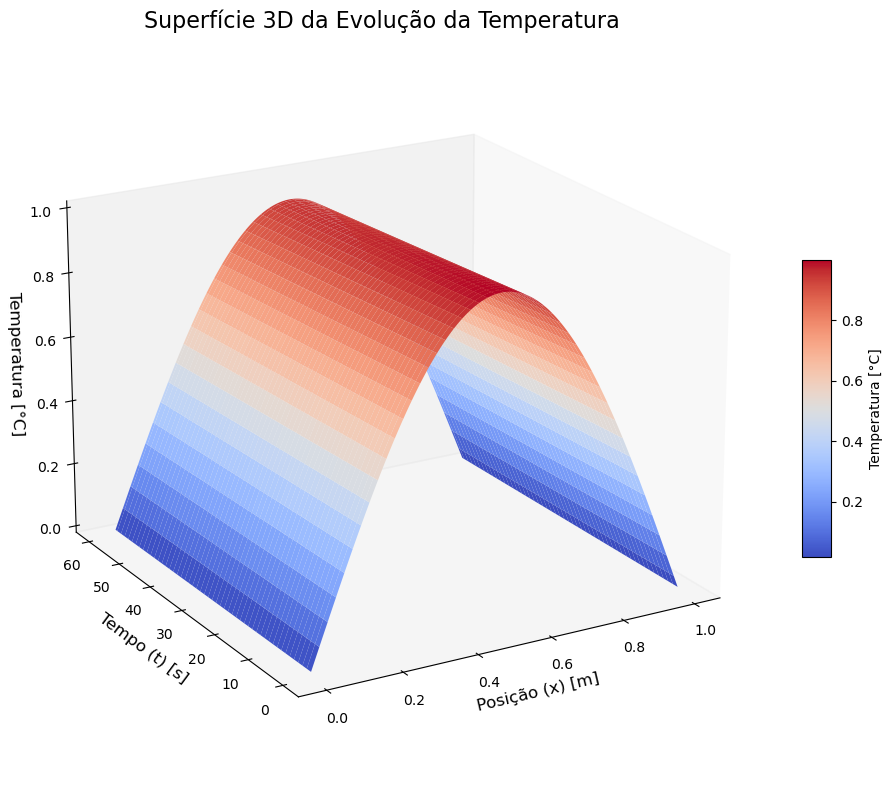

In [23]:
# Criação da Figura e do Eixo 3D
# Um tamanho de figura maior é recomendado para plots 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot da Superfície
# Reutilizamos os dados X, T e U_grid_full calculados na célula do mapa de calor
# X: Posição, T: Tempo, U_grid_full: Temperatura
surf = ax.plot_surface(X, T, U_grid_full, cmap="coolwarm", edgecolor="none")

# Configuração dos Rótulos e Título
ax.set_title("Superfície 3D da Evolução da Temperatura", fontsize=16)
ax.set_xlabel("Posição (x) [m]", fontsize=12)
ax.set_ylabel("Tempo (t) [s]", fontsize=12)
ax.set_zlabel("Temperatura [°C]", fontsize=12)

ax.grid(False)

# Adiciona uma Barra de Cores
# A barra de cores mapeia as cores da superfície para os valores de temperatura
fig.colorbar(surf, shrink=0.4, aspect=10, label="Temperatura [°C]")

# Ajusta o Ângulo de Visualização
# (azimute, elevação) para uma melhor perspectiva
ax.view_init(elev=20, azim=-120)

plt.tight_layout()
plt.show()